In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
import mat73
import random

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

import albumentations as A

In [4]:
data_path = "/media/mountHDD2/nyu/nyu_depth_data_labeled.mat"
raw_data = mat73.loadmat(data_path)
print(type(raw_data))
print(raw_data.keys())

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


<class 'dict'>
dict_keys(['accelData', 'depths', 'images', 'labels', 'names', 'namesToIds', 'rawDepths', 'scenes'])


In [5]:
print(type(raw_data['accelData']))

<class 'numpy.ndarray'>


In [6]:
raw_data['accelData'].shape

(2284, 4)

In [7]:
raw_data['accelData'][0]

array([ 23., 836.,   7.,   1.], dtype=float32)

In [8]:
raw_data['images'].shape

(480, 640, 3, 2284)

In [9]:
raw_data['labels'].shape

(480, 640, 2284)

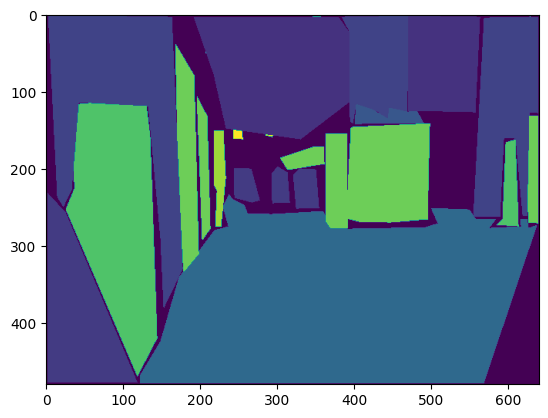

In [10]:
plt.imshow(np.expand_dims(raw_data['labels'][:, :, 1000],  axis = -1))

In [11]:
print(np.max(raw_data['labels'][:, :, 0]))
print(np.min(raw_data['labels'][:, :, 0]))

1296
0


In [12]:
np.unique(raw_data['labels'][:, :, 0])

array([   0,   81,  106,  137,  182,  188,  253,  326,  398,  412,  423,
        450,  683,  730,  760,  763,  782, 1087, 1122, 1225, 1296],
      dtype=uint16)

In [13]:
np.unique(raw_data['labels'][:, :, 1000])

array([   0,  182,  216,  249,  339,  423,  622,  898,  964, 1060, 1240],
      dtype=uint16)

In [14]:
print(raw_data['names'][:10])
print(len(raw_data['names']))

['8-ball', 'a cupboard full of jars and bottles', 'a polythene bag', 'accessories', 'ad pictures', 'advertising hoarding', 'air conditioning', 'air cooller', 'air duct', 'air freshener']
1418


In [15]:
raw_data['depths'].shape

(480, 640, 2284)

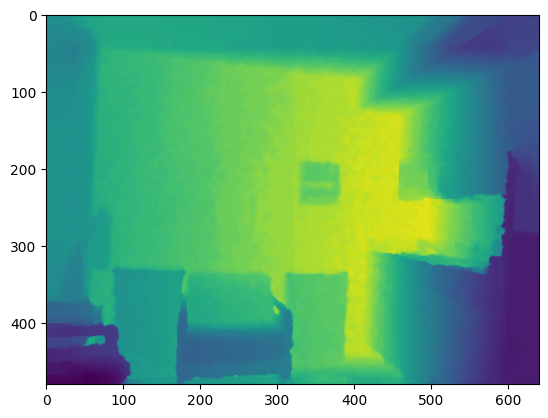

In [16]:
plt.imshow(np.expand_dims(raw_data['depths'][:, :, 0],  axis = -1))

In [17]:
print(np.unique(raw_data['depths'][:, :, 0]))

[1.7927841 1.7930394 1.7960728 ... 3.635616  3.6515915 3.6566987]


In [19]:
raw_data['rawDepths'].shape

(480, 640, 2284)

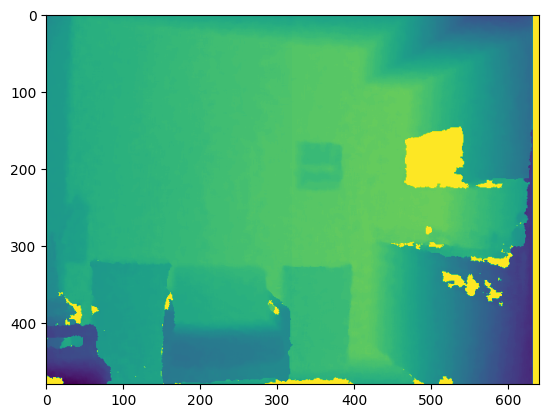

In [20]:
plt.imshow(np.expand_dims(raw_data['rawDepths'][:, :, 0],  axis = -1))

In [21]:
raw_data['scenes'][:10]

[['kitchen_0004'],
 ['kitchen_0004'],
 ['kitchen_0004'],
 ['kitchen_0004'],
 ['kitchen_0004'],
 ['kitchen_0004'],
 ['kitchen_0004'],
 ['kitchen_0004'],
 ['kitchen_0004'],
 ['kitchen_0004']]

In [22]:
transform_lst = [
    A.HorizontalFlip(p=0.2),    
    A.OneOf([
        A.GaussNoise(var_limit=(2.0, 5.0)),
        A.RandomRain(),
        A.RandomSunFlare(src_radius=150) #Make Flare
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.2),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.3,
                      border_mode = cv2.BORDER_CONSTANT),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.PiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),   
        A.Downscale(interpolation = {
            "downscale": cv2.INTER_NEAREST,
            "upscale": cv2.INTER_NEAREST
        }),
    ], p=0.3),
    A.OneOf([
        A.HueSaturationValue(p=0.3),
        A.ColorJitter(p=0.3),
    ], p= 0.3),
    A.RGBShift(p=0.2),
    A.RandomShadow(p=0.2),
    A.ElasticTransform(
        p=0.2, border_mode = cv2.BORDER_CONSTANT,
        alpha_affine = 20
    )
]

In [23]:
class NYU(Dataset):
    def __init__(self, raw_data):
        super().__init__()

        self.cls_cnt = len(raw_data["names"])
        self.images = np.moveaxis(raw_data["images"], -1, 0)
        self.masks = np.moveaxis(raw_data["labels"], -1, 0)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        random.shuffle(transform_lst)

        transform = A.Compose(transform_lst)

        transformed = transform(image = img, mask = mask)
        
        img = transformed['image']
        mask = transformed['mask']

        torch_image = torch.from_numpy(img).permute(-1, 0, 1)
        torch_mask = F.one_hot(
            torch.from_numpy(mask.astype(np.int64)).unsqueeze(0), self.cls_cnt
        ).permute(0, 3, 1, 2)[0].float()

        return (torch_image, torch_mask)

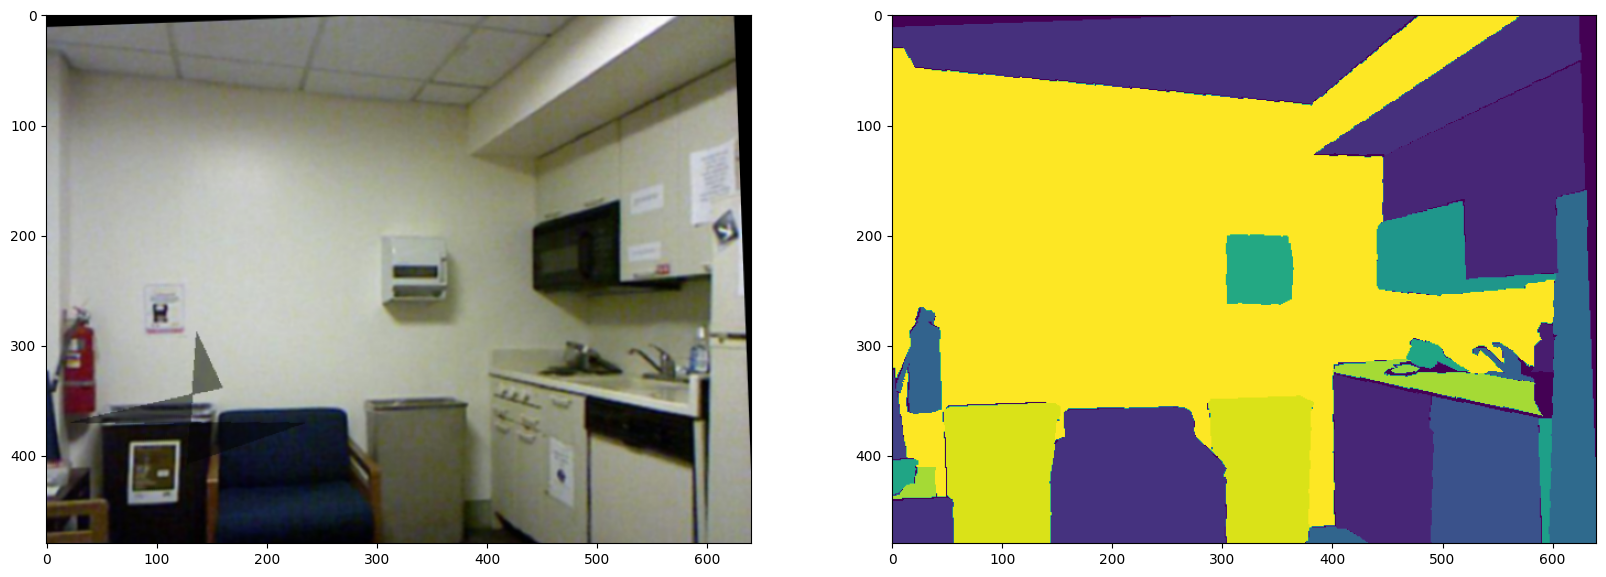

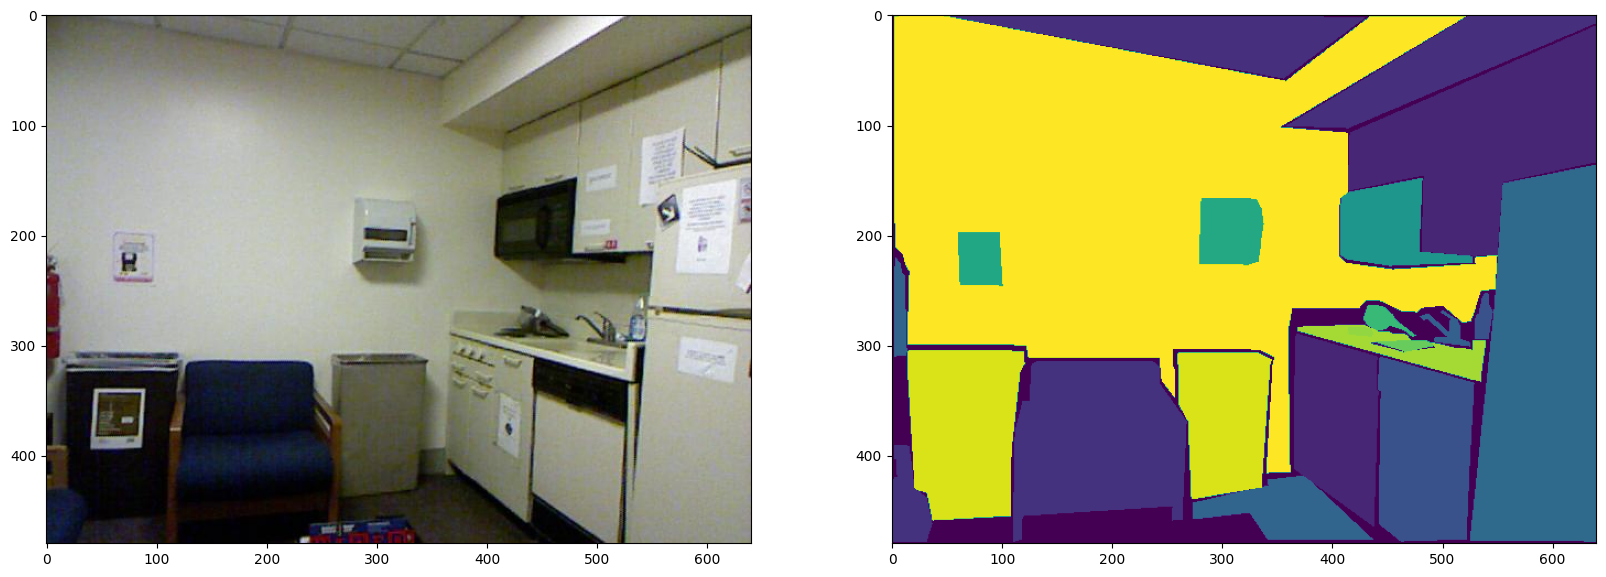

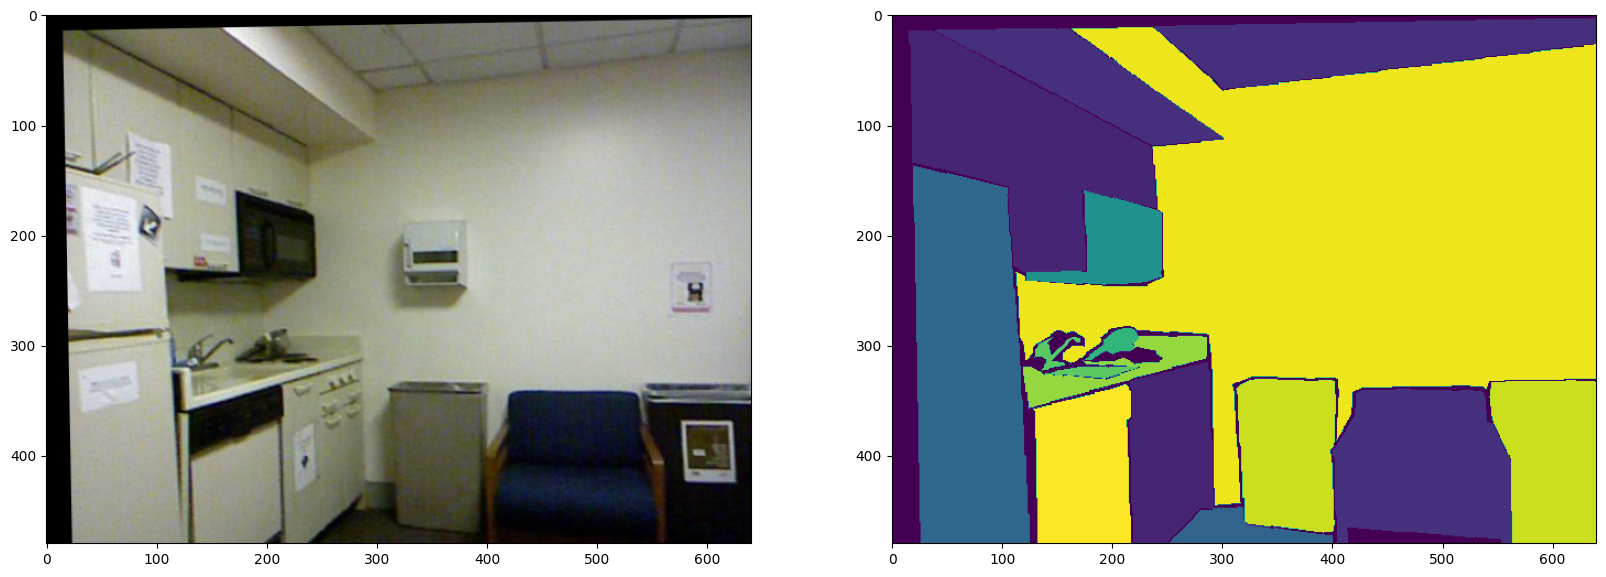

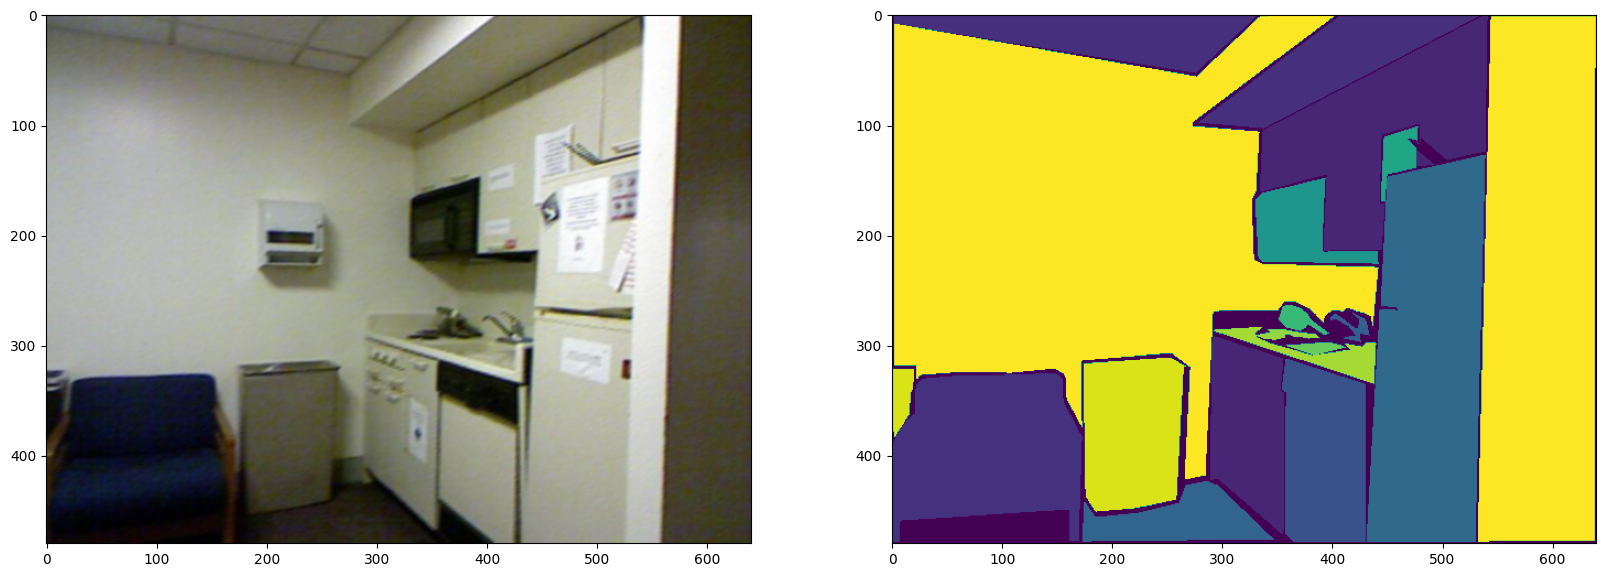

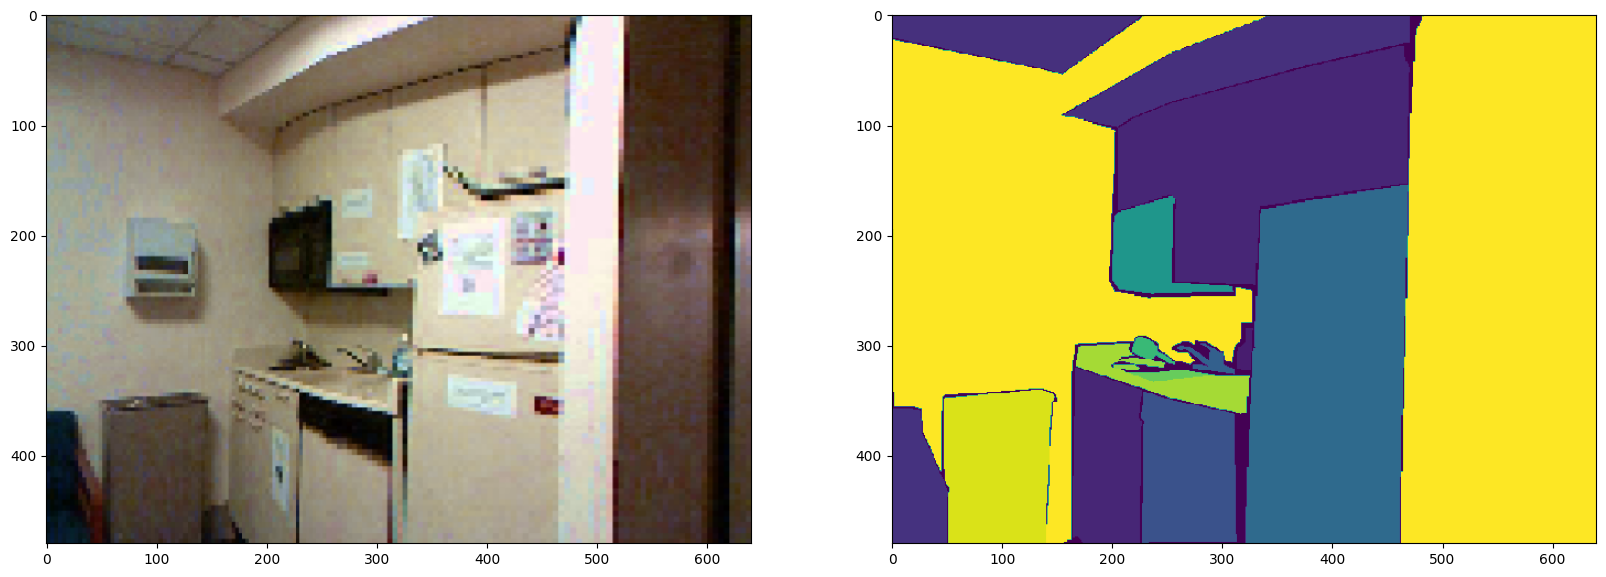

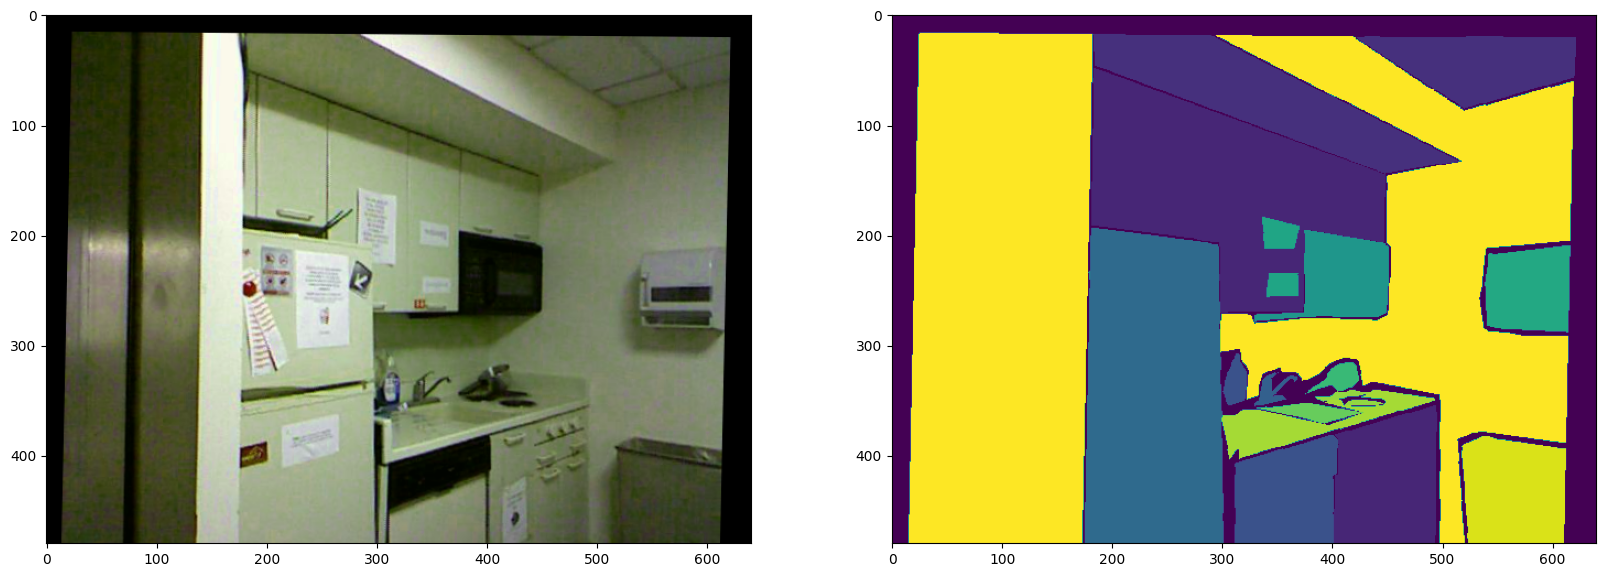

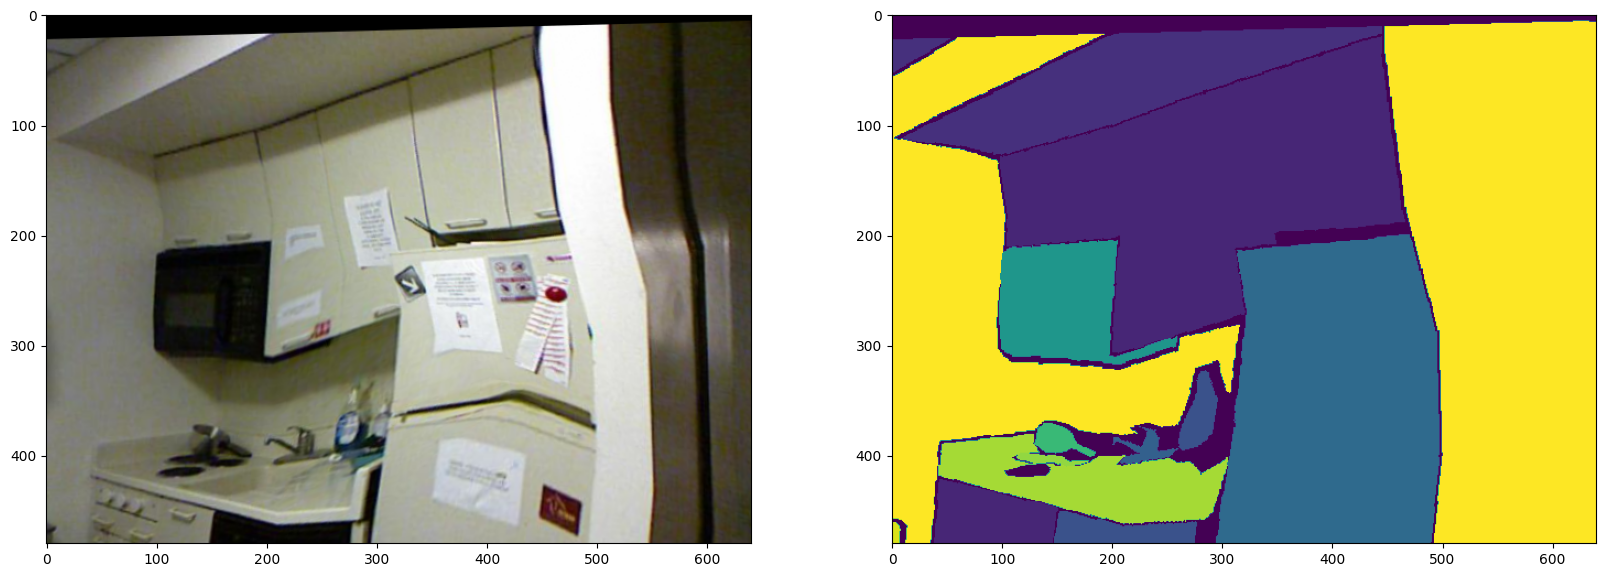

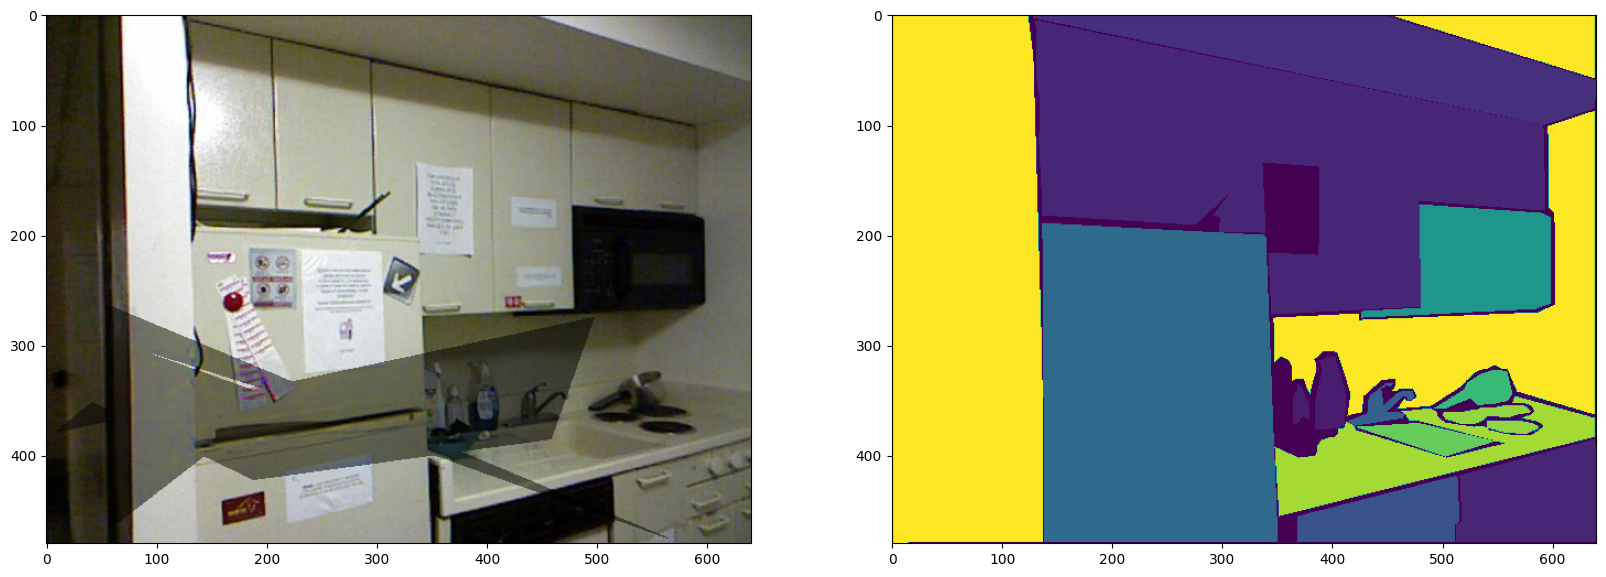

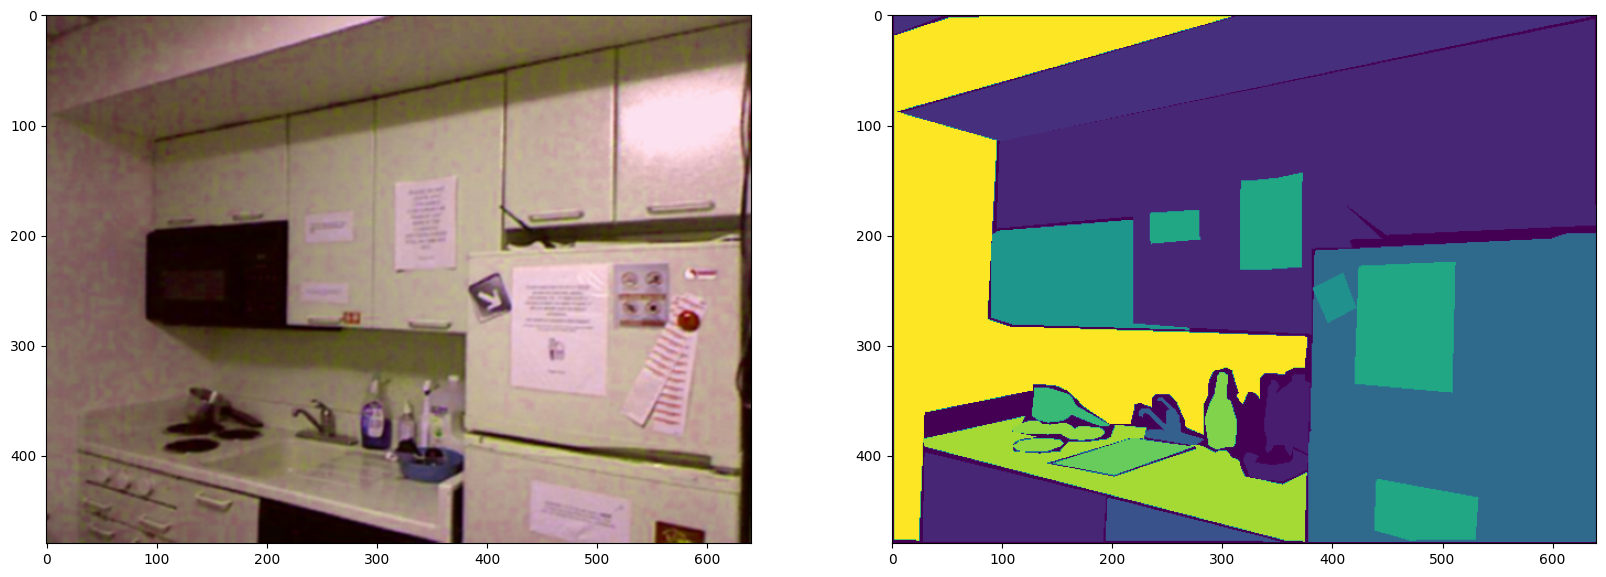

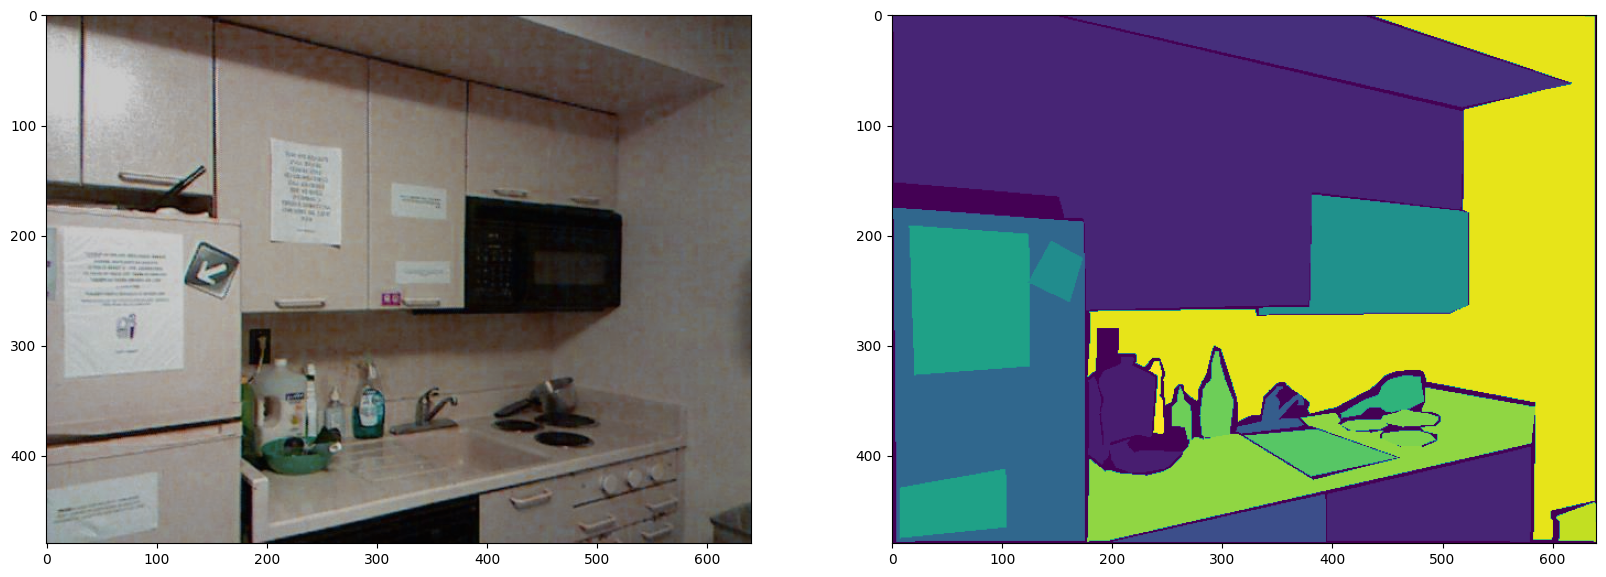

In [24]:
NYU_ds = NYU(raw_data)
for x in range(10):
    img, mask = NYU_ds[x]

    f, axarr = plt.subplots(1, 2, figsize=(20, 15))
    axarr[0].imshow(img.permute(1, -1, 0).numpy())
    axarr[1].imshow(mask.argmax(0).unsqueeze(0).permute(1, -1, 0).numpy())

In [25]:
from tqdm import tqdm
max_lst = []
min_lst = []
for x in tqdm(range(raw_data['labels'].shape[-1])):
    max_lst.append(np.max(np.unique(raw_data['labels'][:, :, x]).astype(np.int64)).tolist())
    min_lst.append(np.min(np.unique(raw_data['labels'][:, :, x]).astype(np.int64)).tolist())
print(max(max_lst))
print(min(min_lst))

100%|█████████████████████████████████████████████████████████████████| 2284/2284 [00:12<00:00, 178.27it/s]

1418
0
